# Проверка гипотез
от uwu gang

### Гипотеза

каждый сезон сериала хуже чем предыдущий


### Сценарий исследования


##### Выборка - телесериалы, имеющие рейтинг на imdb
1. Каждая серия имеет не менее 30 голосов
2. Количество сезонов - не меньше 5

##### Критерии
1. Средняя оценка по сезонам
2. Количество оценок, как еще одна мера популярности
3. Вероятность провала и успеха - резкого изменения оценки

### Препроцессинг

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, normaltest

Выгрузка базы оценок imdb

In [2]:
basics = pd.read_csv('imdb_data/basics.tsv', sep='\t', low_memory=False).set_index('tconst')
episode = pd.read_csv('imdb_data/episode.tsv', sep='\t', low_memory=False).set_index('tconst')
ratings = pd.read_csv('imdb_data/ratings.tsv', sep='\t', low_memory=False).set_index('tconst')

поиск интересующего типа

In [3]:
basics.titleType.unique()

array(['short', 'movie', 'tvEpisode', 'tvSeries', 'tvShort', 'tvMovie',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

присоединие оценок к эпизодам и форматирование данных

In [4]:
episode_rating = episode.join(ratings).join(ratings, on='parentTconst', rsuffix='_parent').dropna()
episode_rating = episode_rating[episode_rating['seasonNumber']!='\\N']
episode_rating.loc[:,'seasonNumber'] = episode_rating.loc[:,'seasonNumber'].astype(int)
episode_rating.loc[:,'episodeNumber'] = episode_rating.loc[:,'episodeNumber'].astype(int)

подсчет минимального количества оценок у сериала и количества сезонов

In [5]:
eligble_series = episode_rating.groupby('parentTconst').agg({'numVotes':'min', 'seasonNumber':'max'})
print(len(eligble_series))

27659


выбор интересующих сериалов. В данном случае меня интересуют только сериалы с количеством сезонов от четырех, а также количество оценок должно быть адекватным. Я считаю что оценки, с колчеством голосов меньше 30 нас не интересуют.

In [6]:
eligble_series = eligble_series[(eligble_series['numVotes']>=30) & (eligble_series['seasonNumber']>=6)]
print(len(eligble_series))

438


Видно, что таких сериалов сильно меньше.
Далее возвращаемся к сериалам, чтобы посчитать средние оценки по сезонам

In [7]:
eligble_episodes = episode_rating.join(eligble_series, on='parentTconst', how='inner', rsuffix='_aggregated')

### Зависимости оценки и количества голосов

In [8]:
seasons_with_metics = eligble_episodes\
        .groupby(['parentTconst', 'seasonNumber']).agg({'averageRating':'mean', 'numVotes':'mean'}).reset_index()
average_rating_right = seasons_with_metics\
        .groupby('seasonNumber').agg({'averageRating':'mean', 'numVotes':'median'}).head(10)

#### Результат

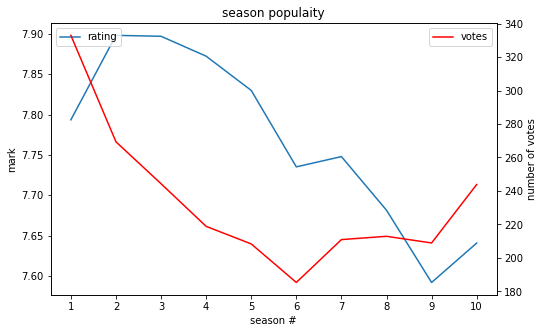

In [9]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ln1 = ax1.plot(average_rating_right['averageRating'], label='rating')
ax2 = ax1.twinx()
ln2 = ax2.plot(average_rating_right['numVotes'], label='votes', color='red')
ax1.legend(loc=2)
ax2.legend()
ax1.set_title('season populaity')
ax1.set_xlabel('season #')
ax1.set_ylabel('mark')
ax2.set_ylabel('number of votes')
plt.xticks(np.arange(1, 11))
plt.show()

In [10]:
sliced_season_with_metrics = seasons_with_metics[seasons_with_metics['seasonNumber']<=6]
print('correlation, p-value')
print(pearsonr(sliced_season_with_metrics['seasonNumber'], sliced_season_with_metrics['averageRating']))

correlation, p-value
(-0.03923004906144282, 0.04849320236111803)


#### Итог: корреляция значима

### Вероятность сильного изменения

In [11]:
def count_change(row):
    print(row)
    if row.name[0] == 1:
        return
    print(seasons_with_metics.loc[(seasons_with_metics['parentTconst'] == row.name[0]) & \
                            (seasons_with_metics['numVotes'] == row.name[1] - 1)]['averageRating'])

In [12]:
changes_limits = np.linspace(-1.5, 1.5, 10)
count_changes = [0] * (len(changes_limits) + 1)
changes_list = []
previous_row = None
for row in seasons_with_metics.iterrows():
    if row[1]['seasonNumber'] > 1:
        change = row[1]['averageRating'] - previous_row[1]['averageRating']
        group_id = (changes_limits <= change).astype(int).sum()
        count_changes[group_id] += 1
        changes_list.append(change)
    previous_row = row

In [13]:
x_labels =  ['(;{:.1f}]'.format(changes_limits[0])] + \
            ['({:.1f}, {:.1f}]'.format(changes_limits[i], changes_limits[i+1]) for i in range(len(changes_limits) - 1)] + \
            ['({:.1f};)'.format(changes_limits[0])]

#### Результат

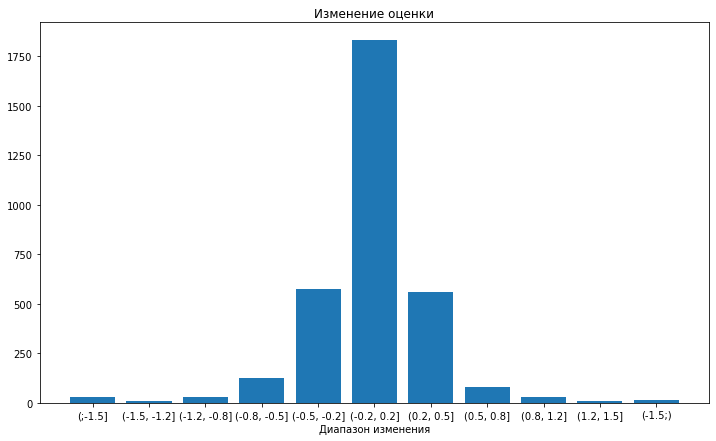

In [16]:
fig = plt.figure(figsize=(12, 7))
plt.bar(x_labels, count_changes)
plt.xticks(x_labels)
plt.title('Изменение оценки')
plt.xlabel('Диапазон изменения')
plt.show()

In [15]:
normaltest(changes_list)

NormaltestResult(statistic=3868.132406441784, pvalue=0.0)

#### Итог: гипотеза неверна